# Annual barley yields per acre in England & Wales 1884 – 1939

参照：https://datamarket.com/data/set/22rj/annual-barley-yields-per-acre-in-england-wales-1884-1939#!ds=22rj&display=line

In [2]:
import numpy as np
import numpy.random as rd
import pandas as pd

import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted", color_codes=True)
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [7]:
df = pd.read_csv("./data/annual-barley-yields-per-acre-in.csv")
df.columns = ["year", "data"]

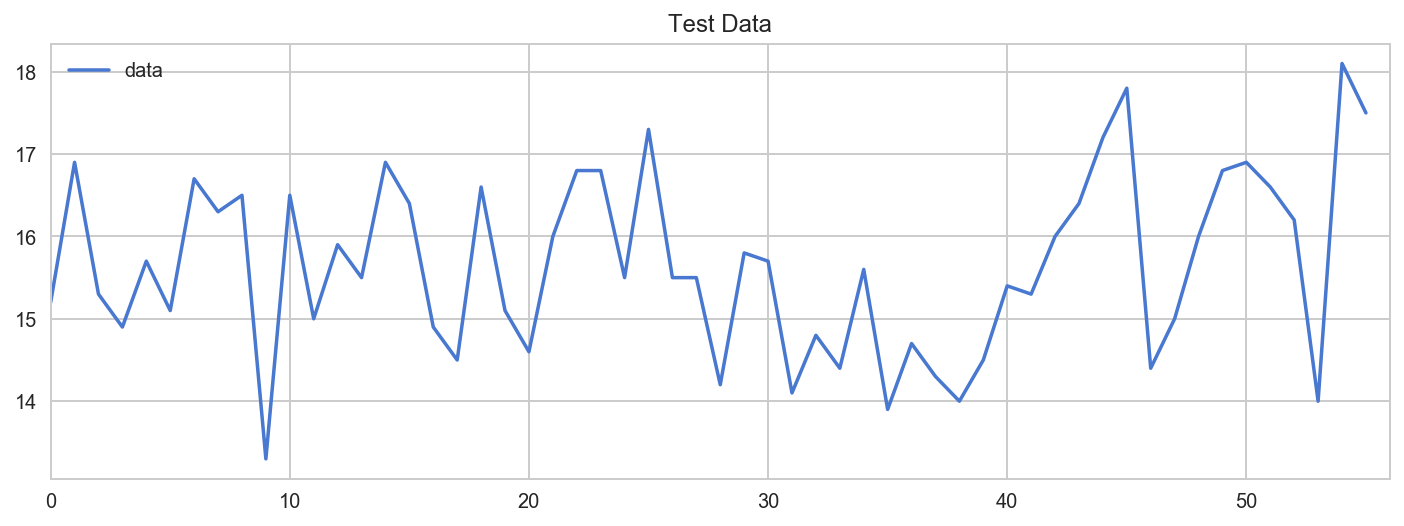

In [8]:
df.plot(figsize = (12,4))
plt.title("Test Data")

In [20]:
class ParticleFilter(object):
    def __init__(self, y, n_particle = 1000, sigma_2 = 0.01, alpha_2 = 0.01, mu_0 = 0.0):
        self.y = y
        self.n_particle = n_particle
        self.sigma_2 = sigma_2
        self.alpha_2 = alpha_2
        self.mu_0 = mu_0
        self.log_likelihood = - np.inf
    
    # likelihood for normal distribution
    def norm_likelihood(self, y, x, s2):
        return (np.sqrt(2 * np.pi * s2))**(-1) * np.exp(-(y - x)**2 / (2 * s2))

    def F_inv(self, w_cumsum, idx, u):
            if np.any(w_cumsum < u) == False:
                return 0
            k = np.max(idx[w_cumsum < u])
            return k + 1
        
    def resampling(self, weights):
        w_cumsum = np.cumsum(weights)
        idx = np.asanyarray(range(self.n_particle)) # labelの生成
        k_list = np.zeros(self.n_particle, dtype = np.int32) # サンプリングしたkのリスト格納場所
        
        # 一様分布から重みに応じてリサンプリングする添え字を取得
        for i, u in enumerate(rd.uniform(0, 1, size = self.n_particle)):
            k = self.F_inv(w_cumsum, idx, u)
            k_list[i] = k
        return k_list

    def resampling2(self, weights):
        """
        計算量の少ない層化サンプリング
        """
        idx = np.asanyarray(range(self.n_particle))
        u0 = rd.uniform(0, 1 / self.n_particle)
        u = [1 / self.n_particle*i + u0 for i in range(self.n_particle)]
        w_cumsum = np.cumsum(weights)
        k = np.asanyarray([self.F_inv(w_cumsum, idx, val) for val in u])
        return k
    
    def simulate(self, seed = 71):
        rd.seed(seed)

        # 時系列データ数
        T = len(self.y)
        
        # 潜在変数
        x = np.zeros((T + 1, self.n_particle))
        x_resampled = np.zeros((T + 1, self.n_particle))
        
        # 潜在変数の初期値
        initial_x = rd.normal(self.mu_0, 1, size = self.n_particle)
        x_resampled[0] = initial_x
        x[0] = initial_x

        # 重み
        w        = np.zeros((T, self.n_particle))
        w_normed = np.zeros((T, self.n_particle))

        l = np.zeros(T) # 時刻毎の尤度

        for t in range(T):
            print("\r calculating... t={}".format(t), end="")
            for i in range(self.n_particle):
                # 1階差分トレンドを適用
                v = rd.normal(0, np.sqrt(self.alpha_2 * self.sigma_2)) # System Noise
                x[t + 1, i] = x_resampled[t, i] + v # システムノイズの付加
                w[t, i] = self.norm_likelihood(self.y[t], x[t+1, i], self.sigma_2)
                # y[t]に対する各粒子の尤度
            w_normed[t] = w[t] / np.sum(w[t]) # 規格化
            l[t] = np.log(np.sum(w[t])) # 各時刻対数尤度

            # Resampling
            #k = self.resampling(w_normed[t]) # リサンプルで取得した粒子の添字
            k = self.resampling2(w_normed[t]) # リサンプルで取得した粒子の添字（層化サンプリング）
            x_resampled[t + 1] = x[t + 1, k]
            
        # 全体の対数尤度
        self.log_likelihood = np.sum(l) - T * np.log(n_particle)
        
        self.x = x
        self.x_resampled = x_resampled
        self.w = w
        self.w_normed = w_normed
        self.l = l
        
    def get_filtered_value(self):
        """
        尤度の重みで加重平均した値でフィルタリングされ値を算出
        """
        return np.diag(np.dot(self.w_normed, self.x[1:].T))
        
    def draw_graph(self):
        # グラフ描画
        T = len(self.y)
        
        plt.figure(figsize=(16,8))
        plt.plot(range(T), self.y, label = "data")
        plt.plot(self.get_filtered_value(), "g", label = "PF")
        
        for t in range(T):
            plt.scatter(np.ones(self.n_particle)*t, self.x[t], color = "r", s = 2,
                        alpha = 0.1)
        
        plt.legend(loc = 'upper right')
        plt.xlabel('time')
        plt.ylabel('value')
        plt.title("sigma^2={0}, alpha^2={1}, log likelihood={2:.3f}"
                  .format(self.sigma_2, self.alpha_2, self.log_likelihood))

In [17]:
# ハイパーパラメーター
a = -2
b = -1
n_particle = 10**3 * 5
sigma_2 = 2**a
alpha_2 = 10**b
mu_0 = 15

In [18]:
pf = ParticleFilter(df.data.values, n_particle, sigma_2, alpha_2, mu_0)
pf.simulate()

 calculating... t=56

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


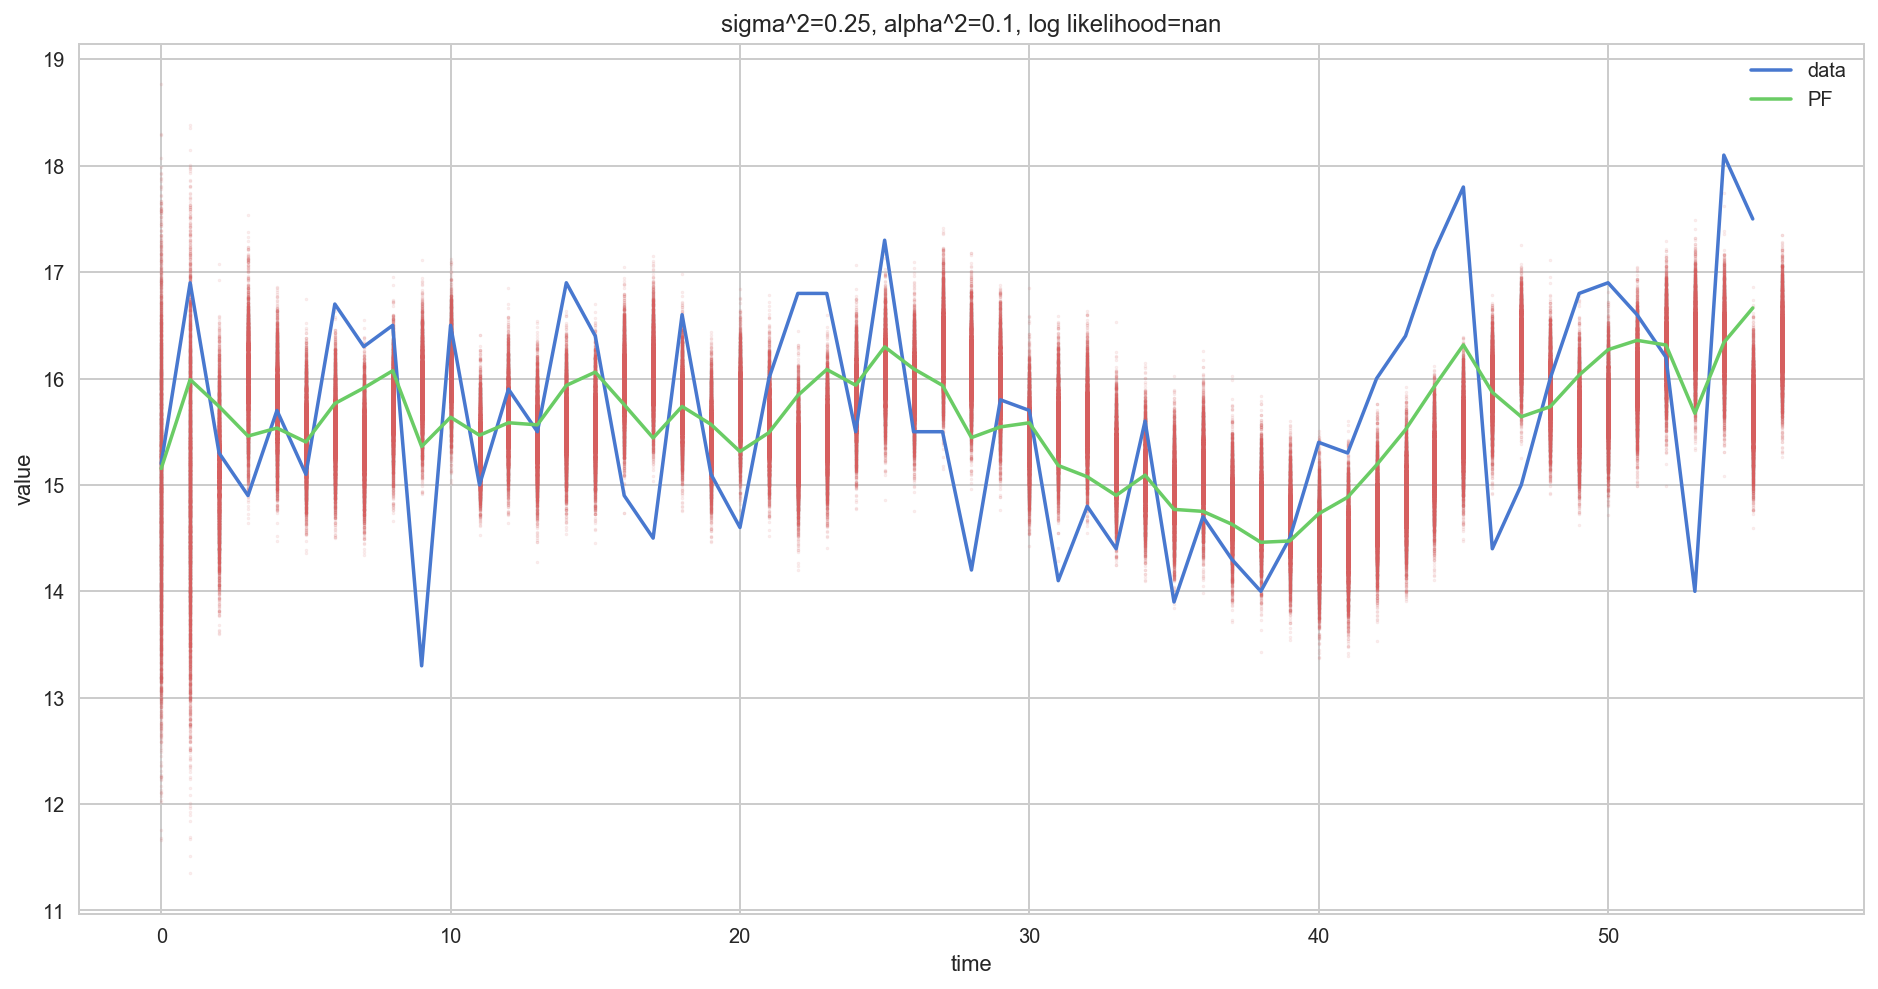

In [19]:
pf.draw_graph()
plt.savefig("plot/1017_particle_filter_yields.png")
plt.show()

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


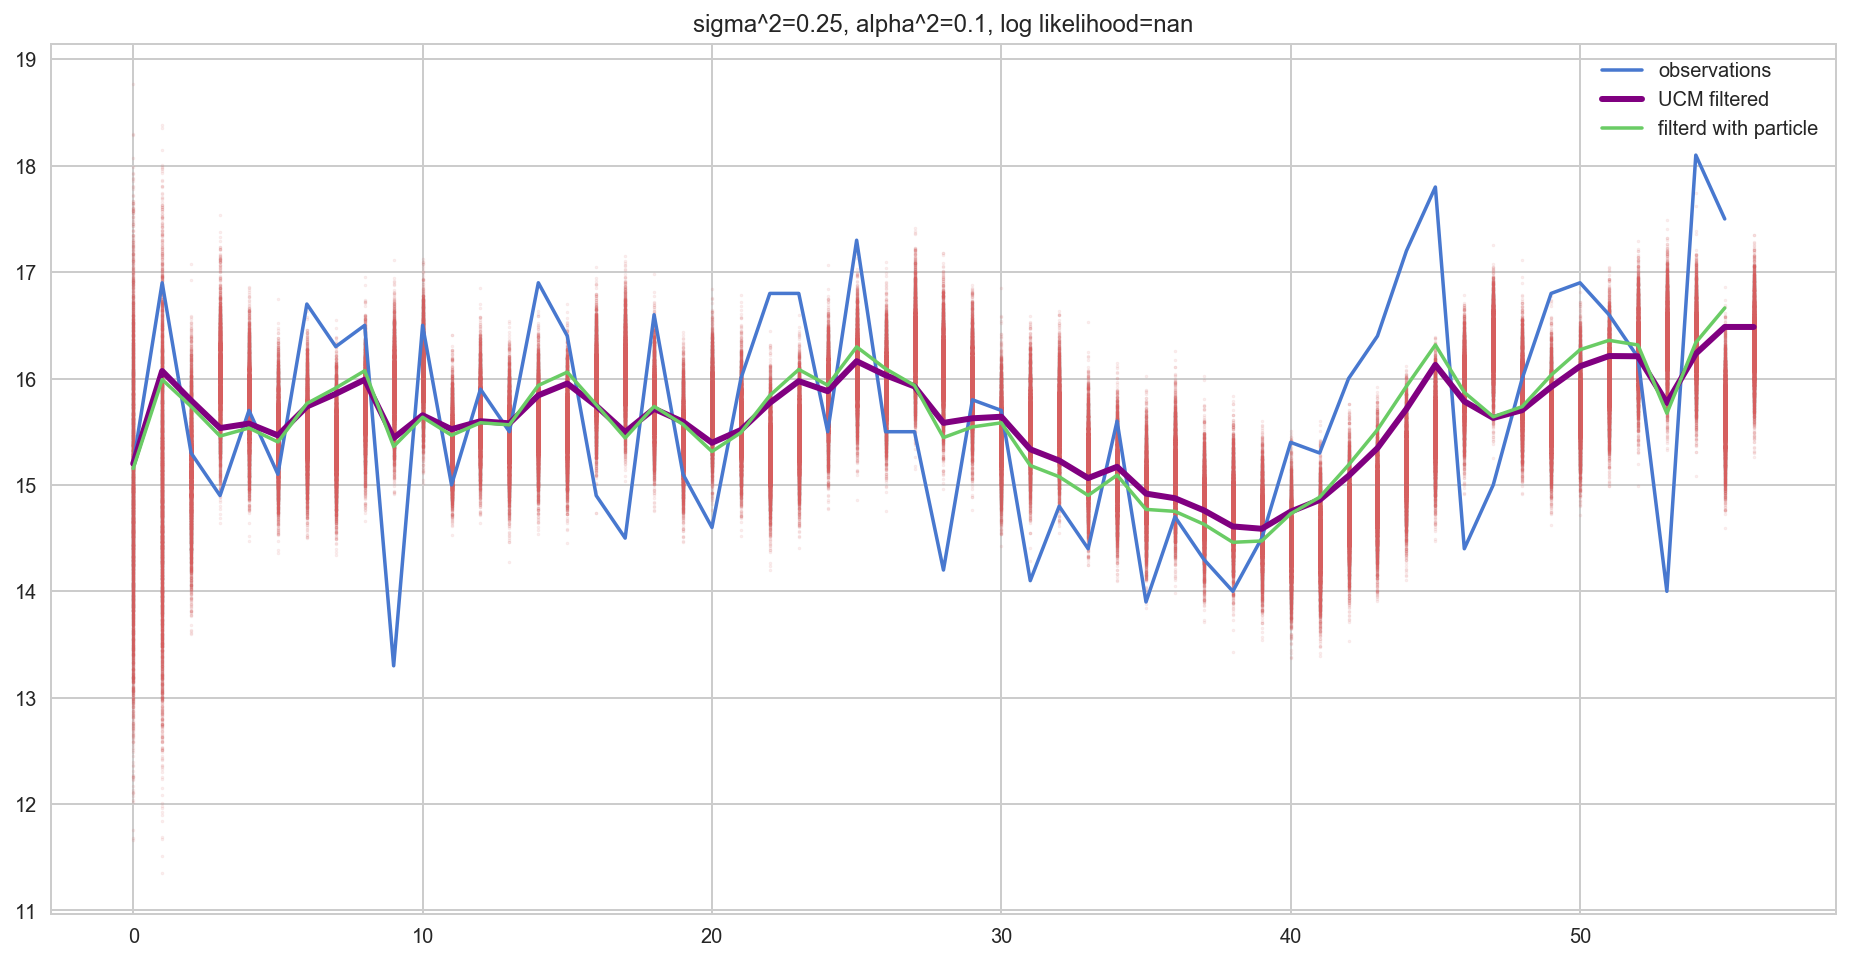

In [21]:
import statsmodels.api as sm

# Fit a local level model
mod_ll = sm.tsa.UnobservedComponents(df.data.values, 'local level')
res_ll = mod_ll.fit()

T = len(pf.y)

plt.figure(figsize = (16,8))
plt.plot(range(T), pf.y, label = "observations")

plt.plot(res_ll.filtered_state.reshape(res_ll.filtered_state.shape[1]), "purple", lw = 3,
         label = "UCM filtered")
plt.plot(pf.get_filtered_value(), "g" ,label = "filterd with particle")
for t in range(T):
    plt.scatter(np.ones(pf.n_particle)*t, pf.x[t], color = "r", s = 2, alpha = 0.1)
plt.title("sigma^2={0}, alpha^2={1}, log likelihood={2:.3f}".format(pf.sigma_2, 
                                                                    pf.alpha_2, 
                                                                    pf.log_likelihood))
plt.legend(loc = "best")
plt.savefig("plot/1017_particle_filter_yields_with_UCM.png")
plt.show()

PFとKFが微妙にズレている．<br>
特に考えずに1017_P_Particle_Filter_classと同様のを用いている